In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
file = pd.read_csv('experiments/nano-1/training.log')
print(str(file))


    epoch       acc      loss   val_acc  val_loss
0       0  0.870223  0.358488  0.893804  0.295876
1       1  0.894853  0.288865  0.891412  0.284911
2       2  0.894817  0.279461  0.893779  0.276442
3       3  0.894094  0.273749  0.894191  0.272503
4       4  0.893582  0.270310  0.893506  0.269570
5       5  0.892511  0.268651  0.890759  0.268282
6       6  0.891690  0.267984  0.889045  0.268065
7       7  0.891082  0.267771  0.890330  0.267713
8       8  0.890976  0.267776  0.889402  0.267675
9       9  0.890710  0.267684  0.890948  0.267767
10     10  0.890573  0.267658  0.890328  0.267640


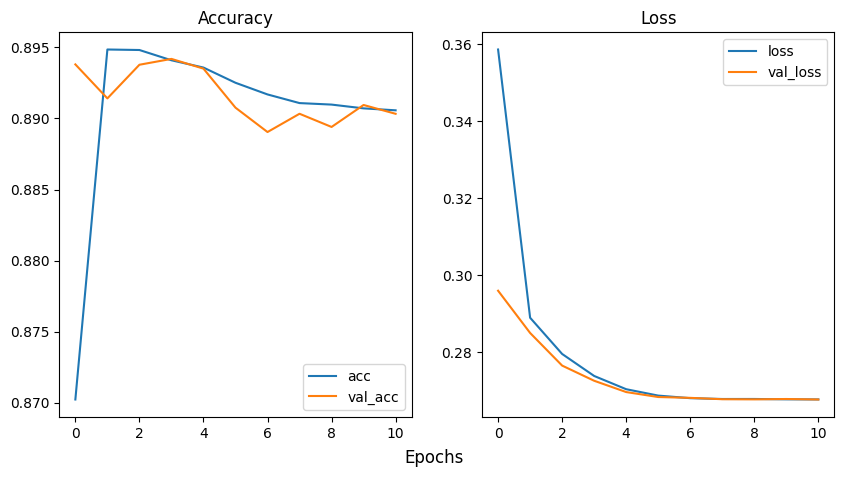

In [34]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10, 5))
axL.plot(file.acc, label='acc')
axL.plot(file.val_acc, label='val_acc')
axL.set_title('Accuracy')
axL.legend(loc='lower right')

axR.plot(file.loss, label='loss')
axR.plot(file.val_loss, label='val_loss')
axR.set_title('Loss')
axR.legend()
fig.supxlabel('Epochs')
fig.savefig('metrics.pdf')

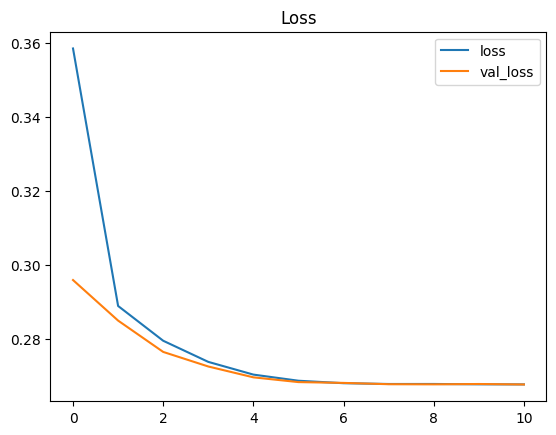

In [24]:
model, history = load_experiment('experiments/nanoPelican-2')

In [25]:
print(model.__dict__)

{'_tracker': <keras.src.utils.tracking.Tracker object at 0x0000017202034710>, '_self_setattr_tracking': True, '_trainable_variables': [], '_non_trainable_variables': [], '_layers': [<InnerProduct name=inner_product_1, built=True>, <Lineq2v2nano name=lineq2v2nano_1, built=True>, <Lineq2v0nano name=lineq2v0nano_1, built=True>], '_metrics': [], '_seed_generators': [], '_lock': False, '_auto_config': <keras.src.saving.serialization_lib.SerializableDict object at 0x00000171FFB58F10>, 'build': <function PelicanNano.build at 0x000001720279C7C0>, '_run_eagerly': False, '_jit_compile': False, 'compiled': True, 'loss': <keras.src.losses.losses.CategoricalCrossentropy object at 0x0000017202775D50>, 'steps_per_execution': 1, '_initial_epoch': None, 'train_function': None, 'test_function': None, 'predict_function': None, '_distribute_strategy': None, '_distribute_reduction_method': None, '_supports_reduce_retracing': True, '_saved_model_inputs_spec': None, '_saved_model_arg_spec': None, '_tracked':

In [26]:
for key in history:
    print(key)

loss = history['loss']
acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']
args = history['args']

acc
loss
val_acc
val_loss
args


In [27]:
for key, val in args.__dict__.items():
    print(key, val)

data_dir zenodo_data/raw
feature_key jetConstituentList
label_key jets
load None
print_summary True
experiment_root experiments
experiment_name nanoPelican
data_interpreter zenodo
n_hidden 1
n_outputs 5
activation relu
dropout_rate 0.0
use_batchnorm True
num_particles 32
num_particles_avg 49
data_format inverted
batch_size 512
epochs 140


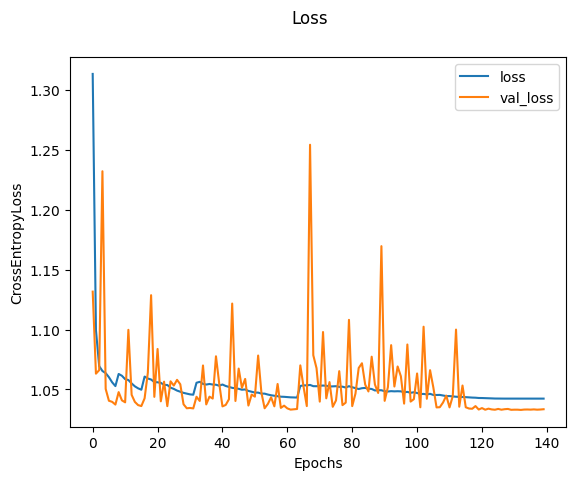

In [28]:
fig, ax = plt.subplots()
ax.plot(loss, label='loss')
ax.plot(val_loss, label='val_loss')
ax.set_ylabel("CrossEntropyLoss")
ax.set_xlabel("Epochs")
fig.suptitle("Loss")
plt.legend()

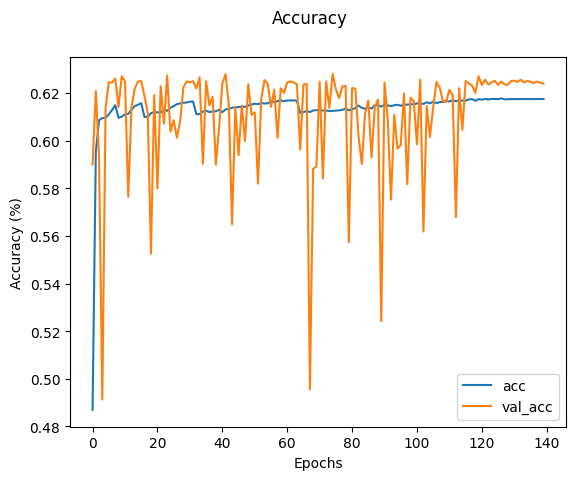

In [29]:
fig, ax = plt.subplots()
ax.plot(acc, label='acc')
ax.plot(val_acc, label='val_acc')
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epochs")
fig.suptitle("Accuracy")
plt.legend()

In [30]:

optimizer = model.optimizer
conf = optimizer.get_config()['learning_rate']#['config']

In [31]:
import tensorflow as tf
scheduler = optimizer._learning_rate
steps = tf.range(scheduler.epochs*scheduler.steps_per_epoch, dtype=tf.float32, delta=scheduler.steps_per_epoch//10)
learning_rate = tf.map_fn(scheduler, steps)


Text(0.5, 0.98, 'LR schedule')

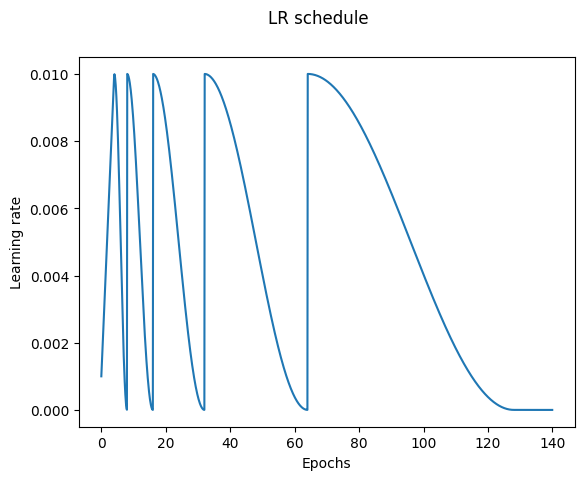

In [32]:
plt.plot(steps / scheduler.steps_per_epoch, learning_rate)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.suptitle("LR schedule")

In [33]:
from sklearn.metrics import roc_curve, auc
from nanopelican.data import load_dataset
from scipy.special import softmax



In [34]:
data = load_dataset('zenodo_data/raw', args, ['test']).test
raw_pred = model.predict(data.x_data)
print(raw_pred)

Loading directory c:\Users\otkul\ETH\vår\project\data\zenodo_data\raw\test
5313/5313 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step
[[  2.1792846    2.3612683    0.30902672  -0.14158422  -0.34547758]
 [  0.11345512  -0.2299625    1.3375895    0.6975917   -0.941225  ]
 [  3.3889897    2.2477875  -16.646069     0.6355965    4.967647  ]
 ...
 [  2.3531418    1.3341825  -12.262958     0.75636095   3.4948978 ]
 [  3.517413     4.1454573    0.7030029   -0.76740295  -0.2814405 ]
 [  2.8331344    3.2202272    0.37269402  -0.437383    -0.27507424]]


In [35]:
pred = softmax(raw_pred, axis=1)
print(pred.shape)

(170000, 5)


In [38]:
particle_labels = {
    0: 'g',
    1: 'q',
    2: 'W',
    3: 'Z',
    4: 't'
}

Text(0.5, 0.98, 'AUC')

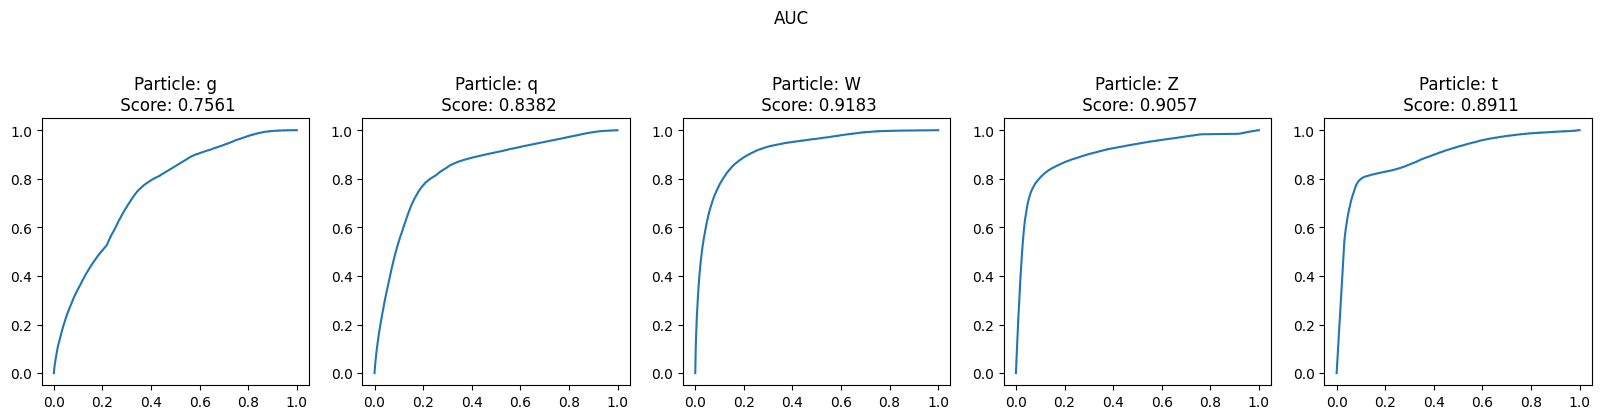

In [40]:




fig, axes = plt.subplots(ncols=data.y_data.shape[-1], figsize=(20, 5))

for n, ax in enumerate(axes):
    y_score = pred[:, n]
    y_true = data.y_data[:, n]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    score = auc(fpr, tpr)
    ax.plot(fpr, tpr)
    ax.set_title(f'Particle: {particle_labels[n]}\n Score: {round(score, 4)}')
    ax.set_aspect('equal')
fig.suptitle("AUC")
# particle_y = data.y_data[:, 0]

